In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import copy
import time
import cv2 as cv
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd
import torchvision.transforms.functional as TF

In [2]:
img_dir = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/'
img_list = os.listdir(img_dir)
print(len(img_list))
valid_ratio = 0.8

31783


In [3]:
class ImageData(Dataset):
    def __init__(self,is_train=True):
        self.is_train = is_train
        self.transform = transforms.Compose([transforms.ToTensor(),])
        self.train_index = int(valid_ratio * len(img_list))
        self.crop = transforms.CenterCrop((218,178))
    def __len__(self):
        if self.is_train:
            return self.train_index
        else:
            return len(img_list) - self.train_index -1
    def __getitem__(self, index):
        if not self.is_train:
            index = self.train_index + index
#         print("hey  "*4 + str(index))
        img = mpimg.imread(img_dir+img_list[index])
        img = self.crop(TF.to_pil_image(img))
        img = self.transform(img)
        img = (img-0.5) /0.5
#         img = (img - 255.0) / 255.0
        return img

In [4]:
batch_size=20
dataset = ImageData()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
device = 'cuda'

torch.Size([3, 218, 178])


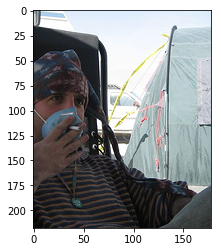

In [5]:
a = next(iter(dataloader))
print(a[0].shape)
img = a[15]
img = img *0.5 + 0.5
plt.imshow(img.permute(1,2,0))

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
IMG_WIDTH = 178
IMG_HEIGHT = 218
latent_size = 200

num_channels_in_encoder = 8

In [8]:
# Encoder Model
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        # ENCODER

        # 64x64x64
        self.e_conv_1 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5, 5), stride=(2, 2)),nn.LeakyReLU()
        )

        # 128x32x32
        self.e_conv_2 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), stride=(2, 2)),
            nn.LeakyReLU()
        )
        
        # 128x32x32
        self.e_block_1 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x32x32
        self.e_block_2 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x32x32
        self.e_block_3 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 32x32x32
        self.e_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=num_channels_in_encoder, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.Tanh()
        )
    def forward(self, x):
        ec1 = self.e_conv_1(x)
        ec2 = self.e_conv_2(ec1)
        eblock1 = self.e_block_1(ec2) + ec2
        eblock2 = self.e_block_2(eblock1) + eblock1
        eblock3 = self.e_block_3(eblock2) + eblock2
        ec3 = self.e_conv_3(eblock3)  # in [-1, 1] from tanh activation
        return ec3

In [9]:
device

'cuda'

In [10]:
netE = Encoder().to(device)
netE.apply(weights_init)
inp = torch.randn(IMG_WIDTH*IMG_HEIGHT*3 * 100)
inp = inp.view((-1,3,IMG_HEIGHT,IMG_WIDTH))
output = netE(inp.to(device))
print(output.shape)
print('The Compression Ratio is :  ' + str((output.shape[1]*output.shape[2]*output.shape[3])/(IMG_WIDTH*IMG_HEIGHT*3)*100) )

torch.Size([100, 8, 54, 44])
The Compression Ratio is :  16.328213586228223


In [11]:
# Generator / Decoder Model

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # DECODER
#         self.latent_fc1 = nn.Sequential(
#             nn.Linear(latent_size,1000),
#             nn.Sigmoid(),
#         )
#         self.latent_fc2 = nn.Sequential(
#             nn.Linear(1000,54*44),
#             nn.Sigmoid(),
#         )
        # 128x64x64
        self.d_up_conv_1 = nn.Sequential(
        nn.Conv2d(in_channels=num_channels_in_encoder, out_channels=64, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=(2, 2), stride=(2, 2))
        )

        # 128x64x64
        self.d_block_1 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x64x64
        self.d_block_2 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x64x64
        self.d_block_3 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 256x128x128
        self.d_up_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.ConvTranspose2d(in_channels=32, out_channels=256, kernel_size=(2, 2), stride=(2, 2))
        )

        # 3x128x128
        self.d_up_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=16, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ReflectionPad2d((3, 3, 3, 3)),
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=(3, 3), stride=(1, 1)),
            nn.Tanh()
        )

        
        
    def forward(self, x):
        uc1 = self.d_up_conv_1(x)
        dblock1 = self.d_block_1(uc1) + uc1
        dblock2 = self.d_block_2(dblock1) + dblock1
        dblock3 = self.d_block_3(dblock2) + dblock2
        uc2 = self.d_up_conv_2(dblock3)
        dec = self.d_up_conv_3(uc2)
        return dec

In [12]:
netG = Generator().to(device)
netG.apply(weights_init)
inp = torch.randn(100*num_channels_in_encoder*54*44).view((-1,num_channels_in_encoder,54,44)).to(device)
output = netG(inp)
print(output.shape)
#218 * 178

torch.Size([100, 3, 218, 178])


In [13]:
torch.cuda.empty_cache()

In [14]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.latent_layer1 = nn.Sequential(
            nn.ConvTranspose2d(num_channels_in_encoder, 12, (3,3), stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer2 = nn.Sequential(
            nn.ConvTranspose2d(12, 16, (3,3), stride=1, padding=2, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer3 = nn.Sequential(
            nn.ConvTranspose2d(16, 24, (3,3), stride=2, padding=2, output_padding=1, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer4 = nn.Sequential(
            nn.ConvTranspose2d(24, 36, (5,5), stride=2, padding=0, output_padding=1, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer5 = nn.Sequential(
            nn.ConvTranspose2d(36, 3, (3,3), stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Tanh(),
        )

        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=64, kernel_size=3,stride = 1,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5,stride = 2,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3,stride = 2,padding=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3,stride = 1,padding=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3,stride = 1,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Tanh(),
        )
        
        
        self.fc1 = nn.Sequential(
            nn.Linear(8*54*44,2000),
            nn.Sigmoid(),
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(2000,100),
            nn.Sigmoid(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(100,1),
            nn.Sigmoid(),
        )
        
        
    def forward(self, x):
        y = x['encoded'].to(device)
        y = self.latent_layer1(y)
        y = self.latent_layer2(y)
        y = self.latent_layer3(y)
        y = self.latent_layer4(y)
        y = self.latent_layer5(y)
#         print(y.shape)
        x = x['img'].to(device)
#         print(x.shape)
        x = torch.cat((x,y),1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
#         print(x.shape)
        x= x.reshape((x.shape[0],-1))
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [15]:
netD = Discriminator().to(device)
netD.apply(weights_init)
inp_x = {}
inp_x['img']=torch.randn(IMG_WIDTH*IMG_HEIGHT*3 * 100).view((-1,3,IMG_HEIGHT,IMG_WIDTH))
inp_x['encoded'] = torch.randn(100*num_channels_in_encoder*54*44).view((-1,num_channels_in_encoder,54,44))
output = netD(inp_x)
output.shape

torch.Size([100, 1])

In [16]:
lr = 0.0002
# Initialize BCELoss function
criterion = nn.BCELoss()
msecriterion = nn.MSELoss()
l1criterion = nn.L1Loss()
# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerE = optim.Adam(netE.parameters(), lr=lr, betas=(0.5, 0.999))

In [17]:
valid_dataset = ImageData(is_train=False)
num_images_to_show = 1
valid_dataloader = DataLoader(valid_dataset, batch_size=num_images_to_show, shuffle=True)
valid_batch = next(iter(valid_dataloader)).to(device)

Starting Training Loop...
[0/9][0/1272] Loss_D: 1.3867	Loss_G: 2.9860	Loss_E: 2.9869	D(x): 0.4819	D(G(z)): 0.4818/0.4619	Progress: 0.01%	Elapsed: 00:00:01	Remaining: 04:50:48


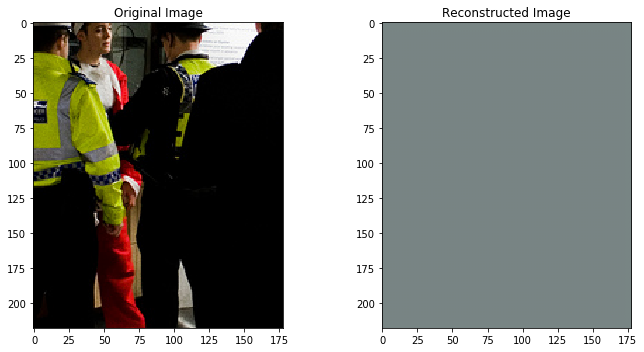

[0/9][50/1272] Loss_D: 1.5248	Loss_G: 1.7353	Loss_E: 1.7367	D(x): 0.3553	D(G(z)): 0.3747/0.6049	Progress: 0.45%	Elapsed: 00:01:27	Remaining: 05:26:21
[0/9][100/1272] Loss_D: 1.1880	Loss_G: 1.7864	Loss_E: 1.7867	D(x): 0.5673	D(G(z)): 0.4119/0.4106	Progress: 0.88%	Elapsed: 00:02:47	Remaining: 05:14:16
[0/9][150/1272] Loss_D: 1.3626	Loss_G: 1.6280	Loss_E: 1.6307	D(x): 0.4963	D(G(z)): 0.4799/0.4837	Progress: 1.32%	Elapsed: 00:04:11	Remaining: 05:14:10
[0/9][200/1272] Loss_D: 1.4986	Loss_G: 3.0541	Loss_E: 3.0543	D(x): 0.5177	D(G(z)): 0.5529/0.4996	Progress: 1.76%	Elapsed: 00:05:39	Remaining: 05:16:42
[0/9][250/1272] Loss_D: 1.3582	Loss_G: 2.3835	Loss_E: 2.3834	D(x): 0.5186	D(G(z)): 0.5009/0.4952	Progress: 2.19%	Elapsed: 00:06:54	Remaining: 05:07:52
[0/9][300/1272] Loss_D: 1.3836	Loss_G: 2.6350	Loss_E: 2.6355	D(x): 0.5070	D(G(z)): 0.5052/0.4963	Progress: 2.63%	Elapsed: 00:08:08	Remaining: 05:01:38
[0/9][350/1272] Loss_D: 1.3529	Loss_G: 2.5878	Loss_E: 2.5882	D(x): 0.5115	D(G(z)): 0.4911/0.494

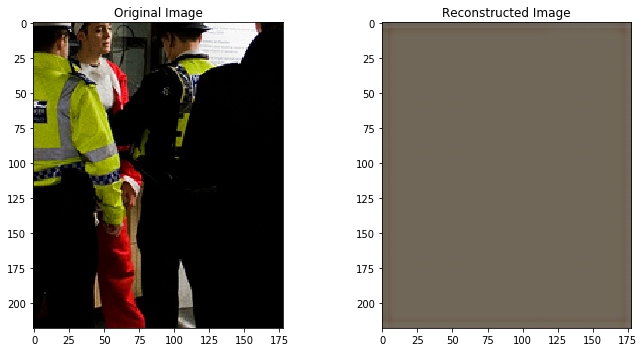

[0/9][550/1272] Loss_D: 1.3859	Loss_G: 2.4988	Loss_E: 2.4989	D(x): 0.5087	D(G(z)): 0.5089/0.5071	Progress: 4.81%	Elapsed: 00:14:25	Remaining: 04:45:07
[0/9][600/1272] Loss_D: 1.3955	Loss_G: 2.0887	Loss_E: 2.0853	D(x): 0.4838	D(G(z)): 0.4882/0.4758	Progress: 5.25%	Elapsed: 00:15:39	Remaining: 04:42:43
[0/9][650/1272] Loss_D: 1.3839	Loss_G: 1.7771	Loss_E: 1.7757	D(x): 0.5022	D(G(z)): 0.5009/0.4989	Progress: 5.69%	Elapsed: 00:16:54	Remaining: 04:40:27
[0/9][700/1272] Loss_D: 1.3817	Loss_G: 1.5981	Loss_E: 1.5983	D(x): 0.5069	D(G(z)): 0.5038/0.4980	Progress: 6.12%	Elapsed: 00:18:08	Remaining: 04:38:13
[0/9][750/1272] Loss_D: 1.3671	Loss_G: 1.6571	Loss_E: 1.6586	D(x): 0.4962	D(G(z)): 0.4841/0.4983	Progress: 6.56%	Elapsed: 00:19:23	Remaining: 04:36:19
[0/9][800/1272] Loss_D: 1.3707	Loss_G: 1.5109	Loss_E: 1.5109	D(x): 0.5210	D(G(z)): 0.5106/0.5065	Progress: 7.00%	Elapsed: 00:20:38	Remaining: 04:34:25
[0/9][850/1272] Loss_D: 1.3635	Loss_G: 1.5118	Loss_E: 1.5115	D(x): 0.4841	D(G(z)): 0.4678/0.48

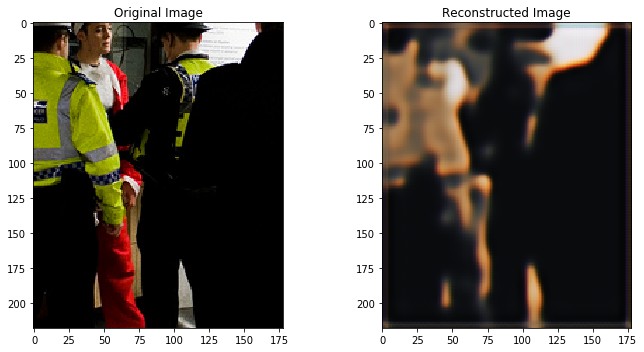

[0/9][1050/1272] Loss_D: 1.3702	Loss_G: 1.6460	Loss_E: 1.6425	D(x): 0.4932	D(G(z)): 0.4811/0.4834	Progress: 9.18%	Elapsed: 00:27:00	Remaining: 04:27:14
[0/9][1100/1272] Loss_D: 1.3897	Loss_G: 1.4723	Loss_E: 1.4749	D(x): 0.5010	D(G(z)): 0.4991/0.5036	Progress: 9.62%	Elapsed: 00:28:15	Remaining: 04:25:35
[0/9][1150/1272] Loss_D: 1.3540	Loss_G: 1.5492	Loss_E: 1.5498	D(x): 0.4962	D(G(z)): 0.4748/0.4905	Progress: 10.05%	Elapsed: 00:29:31	Remaining: 04:24:05
[0/9][1200/1272] Loss_D: 1.4141	Loss_G: 1.5458	Loss_E: 1.5436	D(x): 0.5038	D(G(z)): 0.5145/0.4900	Progress: 10.49%	Elapsed: 00:30:47	Remaining: 04:22:42
[0/9][1250/1272] Loss_D: 1.3747	Loss_G: 1.4383	Loss_E: 1.4423	D(x): 0.5103	D(G(z)): 0.5019/0.4996	Progress: 10.93%	Elapsed: 00:32:02	Remaining: 04:21:09
[1/9][0/1272] Loss_D: 1.3686	Loss_G: 1.4723	Loss_E: 1.4704	D(x): 0.5160	D(G(z)): 0.5040/0.4632	Progress: 11.12%	Elapsed: 00:32:35	Remaining: 04:20:26


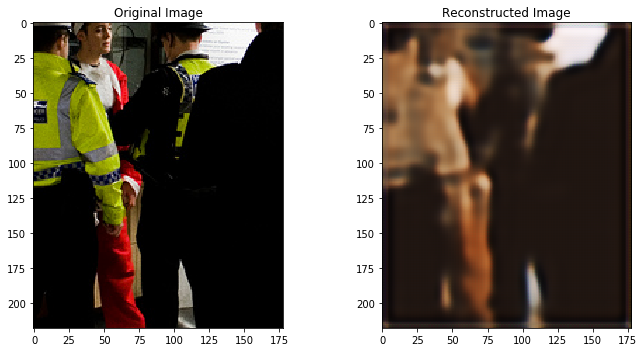

[1/9][50/1272] Loss_D: 1.3386	Loss_G: 1.2688	Loss_E: 1.2728	D(x): 0.5687	D(G(z)): 0.5329/0.5172	Progress: 11.56%	Elapsed: 00:33:41	Remaining: 04:17:53
[1/9][100/1272] Loss_D: 1.2935	Loss_G: 1.4089	Loss_E: 1.4103	D(x): 0.5048	D(G(z)): 0.4394/0.4572	Progress: 11.99%	Elapsed: 00:34:48	Remaining: 04:15:28
[1/9][150/1272] Loss_D: 1.4177	Loss_G: 1.4229	Loss_E: 1.4255	D(x): 0.5354	D(G(z)): 0.5469/0.5330	Progress: 12.43%	Elapsed: 00:35:57	Remaining: 04:13:20
[1/9][200/1272] Loss_D: 1.3329	Loss_G: 1.3088	Loss_E: 1.3103	D(x): 0.5110	D(G(z)): 0.4700/0.5654	Progress: 12.87%	Elapsed: 00:37:04	Remaining: 04:11:04
[1/9][250/1272] Loss_D: 1.2056	Loss_G: 1.4152	Loss_E: 1.4116	D(x): 0.5734	D(G(z)): 0.4364/0.4831	Progress: 13.30%	Elapsed: 00:38:12	Remaining: 04:08:59
[1/9][300/1272] Loss_D: 1.3015	Loss_G: 1.4012	Loss_E: 1.4011	D(x): 0.4938	D(G(z)): 0.4251/0.4779	Progress: 13.74%	Elapsed: 00:39:21	Remaining: 04:07:07
[1/9][350/1272] Loss_D: 1.3124	Loss_G: 1.3242	Loss_E: 1.3232	D(x): 0.5151	D(G(z)): 0.4664

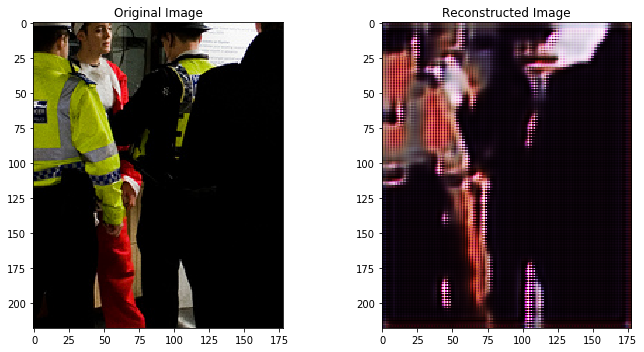

[1/9][550/1272] Loss_D: 1.3618	Loss_G: 1.3896	Loss_E: 1.3846	D(x): 0.5270	D(G(z)): 0.5083/0.4761	Progress: 15.92%	Elapsed: 00:45:02	Remaining: 03:57:46
[1/9][600/1272] Loss_D: 1.4273	Loss_G: 1.5130	Loss_E: 1.5120	D(x): 0.5467	D(G(z)): 0.5507/0.4861	Progress: 16.36%	Elapsed: 00:46:09	Remaining: 03:55:57
[1/9][650/1272] Loss_D: 1.2644	Loss_G: 1.4305	Loss_E: 1.4271	D(x): 0.5733	D(G(z)): 0.4897/0.4439	Progress: 16.80%	Elapsed: 00:47:17	Remaining: 03:54:12
[1/9][700/1272] Loss_D: 1.3702	Loss_G: 1.2967	Loss_E: 1.2898	D(x): 0.5124	D(G(z)): 0.4981/0.5154	Progress: 17.23%	Elapsed: 00:48:24	Remaining: 03:52:27
[1/9][750/1272] Loss_D: 1.2845	Loss_G: 1.4200	Loss_E: 1.4220	D(x): 0.5691	D(G(z)): 0.5028/0.4702	Progress: 17.67%	Elapsed: 00:49:31	Remaining: 03:50:43
[1/9][800/1272] Loss_D: 1.3999	Loss_G: 1.3887	Loss_E: 1.3869	D(x): 0.4766	D(G(z)): 0.4783/0.4834	Progress: 18.11%	Elapsed: 00:50:38	Remaining: 03:49:00
[1/9][850/1272] Loss_D: 1.3666	Loss_G: 1.2790	Loss_E: 1.2809	D(x): 0.4829	D(G(z)): 0.463

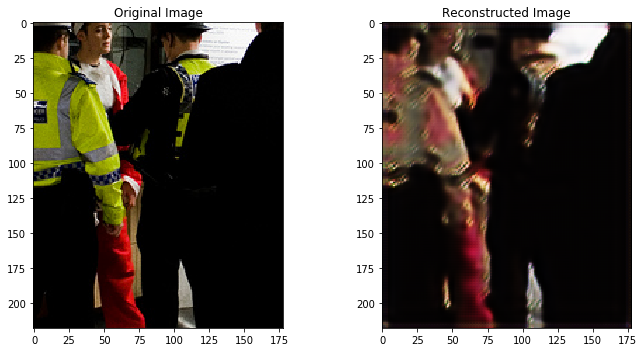

[1/9][1050/1272] Loss_D: 1.3557	Loss_G: 1.3047	Loss_E: 1.3071	D(x): 0.5185	D(G(z)): 0.4913/0.4810	Progress: 20.29%	Elapsed: 00:56:14	Remaining: 03:40:54
[1/9][1100/1272] Loss_D: 1.3046	Loss_G: 1.2542	Loss_E: 1.2578	D(x): 0.5265	D(G(z)): 0.4696/0.4724	Progress: 20.73%	Elapsed: 00:57:21	Remaining: 03:39:21
[1/9][1150/1272] Loss_D: 1.4184	Loss_G: 1.2892	Loss_E: 1.2903	D(x): 0.6437	D(G(z)): 0.6060/0.5423	Progress: 21.17%	Elapsed: 00:58:28	Remaining: 03:37:49
[1/9][1200/1272] Loss_D: 1.3695	Loss_G: 1.2891	Loss_E: 1.2883	D(x): 0.4817	D(G(z)): 0.4671/0.4826	Progress: 21.60%	Elapsed: 00:59:35	Remaining: 03:36:17
[1/9][1250/1272] Loss_D: 1.3511	Loss_G: 1.2811	Loss_E: 1.2807	D(x): 0.5333	D(G(z)): 0.5080/0.4940	Progress: 22.04%	Elapsed: 01:00:42	Remaining: 03:34:46
[2/9][0/1272] Loss_D: 1.4482	Loss_G: 1.3089	Loss_E: 1.3095	D(x): 0.5118	D(G(z)): 0.5417/0.5202	Progress: 22.23%	Elapsed: 01:01:11	Remaining: 03:34:04


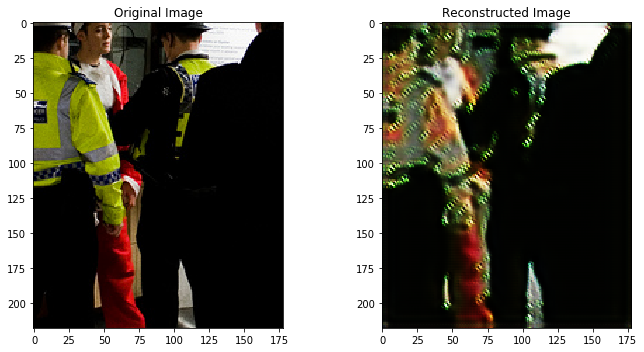

[2/9][50/1272] Loss_D: 1.3596	Loss_G: 1.2127	Loss_E: 1.2124	D(x): 0.5206	D(G(z)): 0.5016/0.4916	Progress: 22.67%	Elapsed: 01:02:19	Remaining: 03:32:36
[2/9][100/1272] Loss_D: 1.3934	Loss_G: 1.3042	Loss_E: 1.3019	D(x): 0.5729	D(G(z)): 0.5610/0.5079	Progress: 23.10%	Elapsed: 01:03:26	Remaining: 03:31:07
[2/9][150/1272] Loss_D: 1.3866	Loss_G: 1.4049	Loss_E: 1.4081	D(x): 0.5060	D(G(z)): 0.4944/0.4722	Progress: 23.54%	Elapsed: 01:04:32	Remaining: 03:29:38
[2/9][200/1272] Loss_D: 1.3615	Loss_G: 1.3679	Loss_E: 1.3641	D(x): 0.5167	D(G(z)): 0.4929/0.4620	Progress: 23.98%	Elapsed: 01:05:39	Remaining: 03:28:10
[2/9][250/1272] Loss_D: 1.3970	Loss_G: 1.3578	Loss_E: 1.3620	D(x): 0.4985	D(G(z)): 0.4974/0.4714	Progress: 24.41%	Elapsed: 01:06:46	Remaining: 03:26:43
[2/9][300/1272] Loss_D: 1.4469	Loss_G: 1.3543	Loss_E: 1.3537	D(x): 0.4864	D(G(z)): 0.4997/0.4911	Progress: 24.85%	Elapsed: 01:07:53	Remaining: 03:25:17
[2/9][350/1272] Loss_D: 1.2959	Loss_G: 1.2583	Loss_E: 1.2584	D(x): 0.5231	D(G(z)): 0.4655

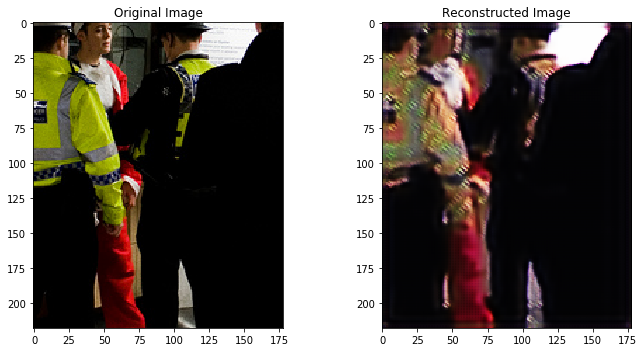

[2/9][550/1272] Loss_D: 1.3806	Loss_G: 1.2927	Loss_E: 1.2979	D(x): 0.5041	D(G(z)): 0.4948/0.5009	Progress: 27.04%	Elapsed: 01:13:29	Remaining: 03:18:21
[2/9][600/1272] Loss_D: 1.3550	Loss_G: 1.2237	Loss_E: 1.2278	D(x): 0.5191	D(G(z)): 0.4952/0.5181	Progress: 27.47%	Elapsed: 01:14:37	Remaining: 03:16:59
[2/9][650/1272] Loss_D: 1.3820	Loss_G: 1.2358	Loss_E: 1.2376	D(x): 0.4987	D(G(z)): 0.4893/0.4873	Progress: 27.91%	Elapsed: 01:15:44	Remaining: 03:15:38
[2/9][700/1272] Loss_D: 1.3546	Loss_G: 1.2475	Loss_E: 1.2456	D(x): 0.5163	D(G(z)): 0.4887/0.4767	Progress: 28.35%	Elapsed: 01:16:51	Remaining: 03:14:17
[2/9][750/1272] Loss_D: 1.3507	Loss_G: 1.1432	Loss_E: 1.1447	D(x): 0.5036	D(G(z)): 0.4777/0.5053	Progress: 28.78%	Elapsed: 01:17:58	Remaining: 03:12:57
[2/9][800/1272] Loss_D: 1.4211	Loss_G: 1.3009	Loss_E: 1.3018	D(x): 0.5005	D(G(z)): 0.5130/0.5027	Progress: 29.22%	Elapsed: 01:19:06	Remaining: 03:11:38
[2/9][850/1272] Loss_D: 1.3464	Loss_G: 1.1544	Loss_E: 1.1456	D(x): 0.5831	D(G(z)): 0.537

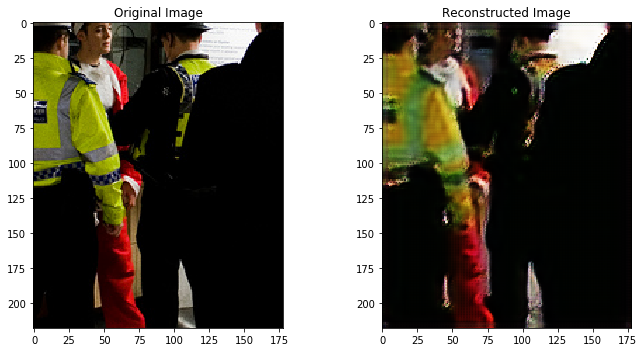

[2/9][1050/1272] Loss_D: 1.4153	Loss_G: 1.2751	Loss_E: 1.2760	D(x): 0.4915	D(G(z)): 0.5025/0.4954	Progress: 31.40%	Elapsed: 01:24:44	Remaining: 03:05:05
[2/9][1100/1272] Loss_D: 1.3604	Loss_G: 1.0852	Loss_E: 1.0855	D(x): 0.5161	D(G(z)): 0.4975/0.5024	Progress: 31.84%	Elapsed: 01:25:52	Remaining: 03:03:49
[2/9][1150/1272] Loss_D: 1.3843	Loss_G: 1.2467	Loss_E: 1.2453	D(x): 0.5337	D(G(z)): 0.5268/0.4990	Progress: 32.28%	Elapsed: 01:27:00	Remaining: 03:02:33
[2/9][1200/1272] Loss_D: 1.3675	Loss_G: 1.1913	Loss_E: 1.1875	D(x): 0.5137	D(G(z)): 0.4973/0.5011	Progress: 32.71%	Elapsed: 01:28:07	Remaining: 03:01:15
[2/9][1250/1272] Loss_D: 1.3470	Loss_G: 1.2104	Loss_E: 1.2073	D(x): 0.5009	D(G(z)): 0.4764/0.4854	Progress: 33.15%	Elapsed: 01:29:14	Remaining: 02:59:58
[3/9][0/1272] Loss_D: 1.4158	Loss_G: 1.1841	Loss_E: 1.1878	D(x): 0.4551	D(G(z)): 0.4595/0.4772	Progress: 33.34%	Elapsed: 01:29:43	Remaining: 02:59:22


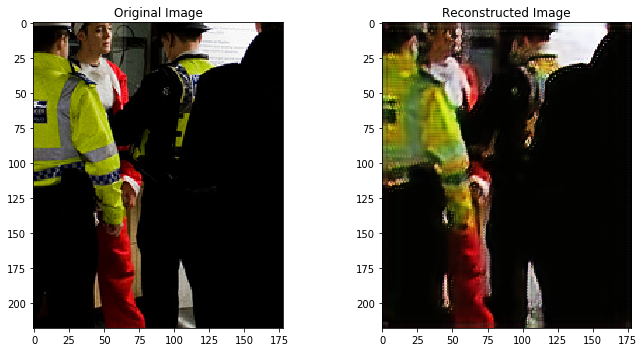

[3/9][50/1272] Loss_D: 1.4343	Loss_G: 1.1737	Loss_E: 1.1753	D(x): 0.5417	D(G(z)): 0.5565/0.5219	Progress: 33.78%	Elapsed: 01:30:51	Remaining: 02:58:06
[3/9][100/1272] Loss_D: 1.3172	Loss_G: 1.2371	Loss_E: 1.2357	D(x): 0.5524	D(G(z)): 0.5033/0.5087	Progress: 34.22%	Elapsed: 01:31:58	Remaining: 02:56:49
[3/9][150/1272] Loss_D: 1.3647	Loss_G: 1.1317	Loss_E: 1.1292	D(x): 0.5079	D(G(z)): 0.4900/0.5093	Progress: 34.65%	Elapsed: 01:33:05	Remaining: 02:55:32
[3/9][200/1272] Loss_D: 1.3780	Loss_G: 1.1967	Loss_E: 1.2029	D(x): 0.4833	D(G(z)): 0.4771/0.4909	Progress: 35.09%	Elapsed: 01:34:12	Remaining: 02:54:16
[3/9][250/1272] Loss_D: 1.3731	Loss_G: 1.2002	Loss_E: 1.2037	D(x): 0.5353	D(G(z)): 0.5241/0.4909	Progress: 35.53%	Elapsed: 01:35:20	Remaining: 02:53:01
[3/9][300/1272] Loss_D: 1.3975	Loss_G: 1.1687	Loss_E: 1.1673	D(x): 0.4798	D(G(z)): 0.4818/0.4880	Progress: 35.96%	Elapsed: 01:36:27	Remaining: 02:51:44
[3/9][350/1272] Loss_D: 1.3895	Loss_G: 1.2690	Loss_E: 1.2686	D(x): 0.4707	D(G(z)): 0.4649

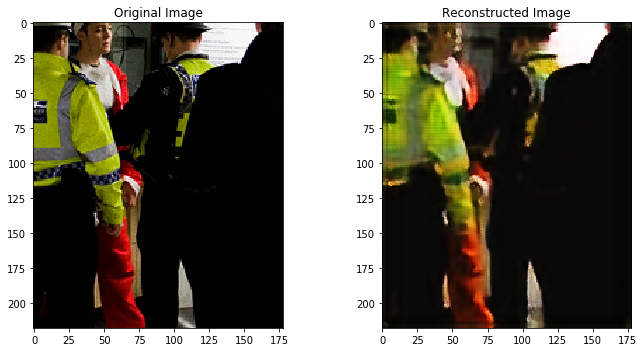

[3/9][550/1272] Loss_D: 1.3844	Loss_G: 1.1981	Loss_E: 1.1966	D(x): 0.5188	D(G(z)): 0.5137/0.5182	Progress: 38.15%	Elapsed: 01:42:05	Remaining: 02:45:32
[3/9][600/1272] Loss_D: 1.3576	Loss_G: 1.0947	Loss_E: 1.0937	D(x): 0.5380	D(G(z)): 0.5185/0.5095	Progress: 38.58%	Elapsed: 01:43:13	Remaining: 02:44:19
[3/9][650/1272] Loss_D: 1.3875	Loss_G: 1.1047	Loss_E: 1.1045	D(x): 0.5064	D(G(z)): 0.5063/0.4937	Progress: 39.02%	Elapsed: 01:44:22	Remaining: 02:43:06
[3/9][700/1272] Loss_D: 1.3869	Loss_G: 1.1448	Loss_E: 1.1445	D(x): 0.5171	D(G(z)): 0.5171/0.5061	Progress: 39.46%	Elapsed: 01:45:30	Remaining: 02:41:53
[3/9][750/1272] Loss_D: 1.3151	Loss_G: 1.2586	Loss_E: 1.2615	D(x): 0.4653	D(G(z)): 0.4068/0.4505	Progress: 39.89%	Elapsed: 01:46:37	Remaining: 02:40:39
[3/9][800/1272] Loss_D: 1.4342	Loss_G: 1.1505	Loss_E: 1.1559	D(x): 0.5451	D(G(z)): 0.5582/0.5106	Progress: 40.33%	Elapsed: 01:47:45	Remaining: 02:39:26
[3/9][850/1272] Loss_D: 1.3835	Loss_G: 1.0631	Loss_E: 1.0619	D(x): 0.5101	D(G(z)): 0.508

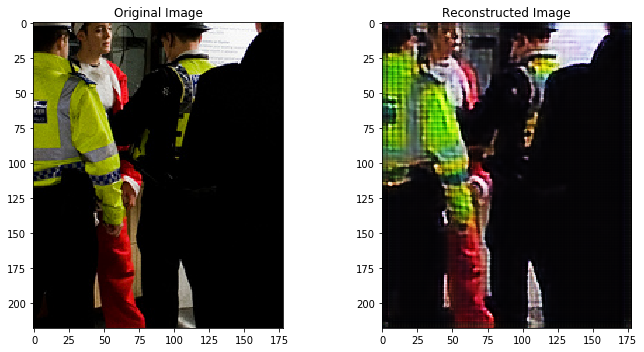

[3/9][1050/1272] Loss_D: 1.3843	Loss_G: 1.0464	Loss_E: 1.0413	D(x): 0.5197	D(G(z)): 0.5167/0.5093	Progress: 42.51%	Elapsed: 01:53:24	Remaining: 02:33:21
[3/9][1100/1272] Loss_D: 1.3351	Loss_G: 1.1683	Loss_E: 1.1693	D(x): 0.5083	D(G(z)): 0.4738/0.4796	Progress: 42.95%	Elapsed: 01:54:32	Remaining: 02:32:07
[3/9][1150/1272] Loss_D: 1.3416	Loss_G: 1.2927	Loss_E: 1.2968	D(x): 0.5267	D(G(z)): 0.4919/0.4666	Progress: 43.39%	Elapsed: 01:55:39	Remaining: 02:30:54
[3/9][1200/1272] Loss_D: 1.3472	Loss_G: 1.1275	Loss_E: 1.1334	D(x): 0.5366	D(G(z)): 0.5090/0.4912	Progress: 43.82%	Elapsed: 01:56:46	Remaining: 02:29:41
[3/9][1250/1272] Loss_D: 1.3691	Loss_G: 1.1355	Loss_E: 1.1330	D(x): 0.4929	D(G(z)): 0.4804/0.5021	Progress: 44.26%	Elapsed: 01:57:54	Remaining: 02:28:29
[4/9][0/1272] Loss_D: 1.3892	Loss_G: 1.2156	Loss_E: 1.2133	D(x): 0.4937	D(G(z)): 0.4923/0.5138	Progress: 44.45%	Elapsed: 01:58:24	Remaining: 02:27:57


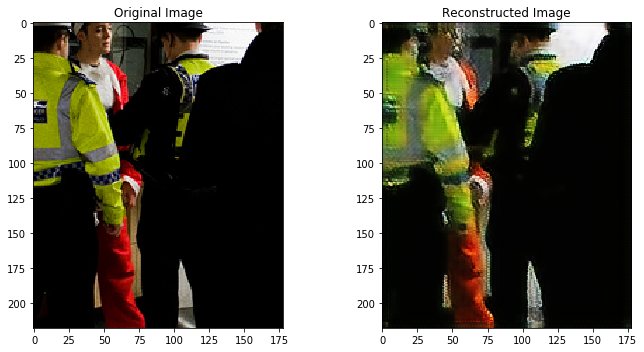

[4/9][50/1272] Loss_D: 1.3684	Loss_G: 1.1087	Loss_E: 1.1128	D(x): 0.4990	D(G(z)): 0.4863/0.4791	Progress: 44.89%	Elapsed: 01:59:32	Remaining: 02:26:45
[4/9][100/1272] Loss_D: 1.3809	Loss_G: 1.1788	Loss_E: 1.1774	D(x): 0.5237	D(G(z)): 0.5150/0.4947	Progress: 45.33%	Elapsed: 02:00:39	Remaining: 02:25:32
[4/9][150/1272] Loss_D: 1.3863	Loss_G: 1.2260	Loss_E: 1.2232	D(x): 0.5155	D(G(z)): 0.5131/0.4937	Progress: 45.76%	Elapsed: 02:01:47	Remaining: 02:24:20
[4/9][200/1272] Loss_D: 1.3921	Loss_G: 1.0977	Loss_E: 1.0943	D(x): 0.5160	D(G(z)): 0.5178/0.5139	Progress: 46.20%	Elapsed: 02:02:54	Remaining: 02:23:07
[4/9][250/1272] Loss_D: 1.3535	Loss_G: 1.1418	Loss_E: 1.1390	D(x): 0.5254	D(G(z)): 0.5026/0.4794	Progress: 46.64%	Elapsed: 02:04:02	Remaining: 02:21:55
[4/9][300/1272] Loss_D: 1.3395	Loss_G: 1.2247	Loss_E: 1.2249	D(x): 0.5080	D(G(z)): 0.4782/0.4603	Progress: 47.07%	Elapsed: 02:05:10	Remaining: 02:20:44
[4/9][350/1272] Loss_D: 1.3570	Loss_G: 1.0849	Loss_E: 1.0924	D(x): 0.5715	D(G(z)): 0.5407

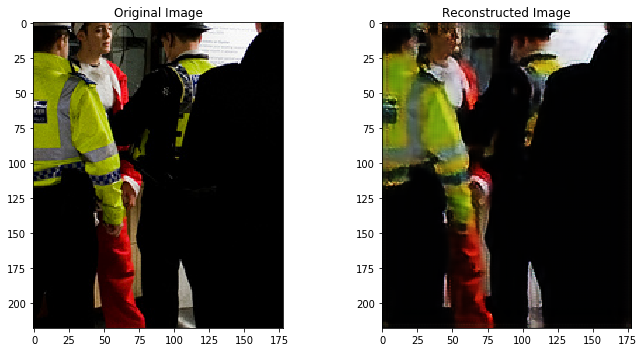

[4/9][550/1272] Loss_D: 1.3548	Loss_G: 1.1238	Loss_E: 1.1275	D(x): 0.5209	D(G(z)): 0.4964/0.4943	Progress: 49.26%	Elapsed: 02:10:54	Remaining: 02:14:51
[4/9][600/1272] Loss_D: 1.3663	Loss_G: 1.1102	Loss_E: 1.1085	D(x): 0.5003	D(G(z)): 0.4844/0.4793	Progress: 49.69%	Elapsed: 02:12:03	Remaining: 02:13:41
[4/9][650/1272] Loss_D: 1.4178	Loss_G: 1.1741	Loss_E: 1.1755	D(x): 0.4990	D(G(z)): 0.5102/0.4938	Progress: 50.13%	Elapsed: 02:13:11	Remaining: 02:12:29
[4/9][700/1272] Loss_D: 1.3906	Loss_G: 1.2337	Loss_E: 1.2340	D(x): 0.4696	D(G(z)): 0.4700/0.4874	Progress: 50.57%	Elapsed: 02:14:20	Remaining: 02:11:19
[4/9][750/1272] Loss_D: 1.3589	Loss_G: 1.1215	Loss_E: 1.1230	D(x): 0.5486	D(G(z)): 0.5244/0.5136	Progress: 51.00%	Elapsed: 02:15:31	Remaining: 02:10:11
[4/9][800/1272] Loss_D: 1.4309	Loss_G: 1.1333	Loss_E: 1.1335	D(x): 0.5017	D(G(z)): 0.5133/0.5459	Progress: 51.44%	Elapsed: 02:16:41	Remaining: 02:09:02
[4/9][850/1272] Loss_D: 1.3903	Loss_G: 1.1622	Loss_E: 1.1620	D(x): 0.4858	D(G(z)): 0.487

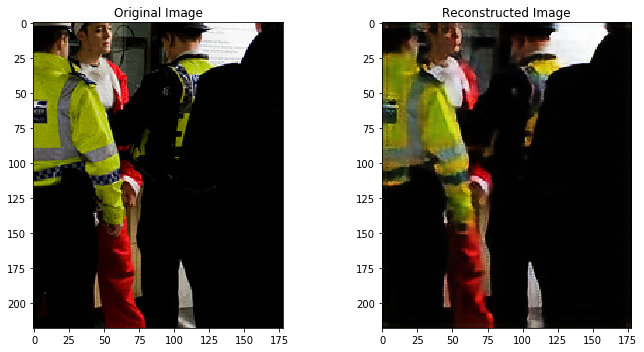

[4/9][1050/1272] Loss_D: 1.3810	Loss_G: 1.1047	Loss_E: 1.1036	D(x): 0.5567	D(G(z)): 0.5406/0.5104	Progress: 53.63%	Elapsed: 02:22:22	Remaining: 02:03:07
[4/9][1100/1272] Loss_D: 1.3594	Loss_G: 1.0910	Loss_E: 1.0907	D(x): 0.5118	D(G(z)): 0.4913/0.5185	Progress: 54.06%	Elapsed: 02:23:29	Remaining: 02:01:56
[4/9][1150/1272] Loss_D: 1.3759	Loss_G: 1.1155	Loss_E: 1.1150	D(x): 0.5060	D(G(z)): 0.4949/0.4824	Progress: 54.50%	Elapsed: 02:24:36	Remaining: 02:00:44
[4/9][1200/1272] Loss_D: 1.3809	Loss_G: 1.0742	Loss_E: 1.0754	D(x): 0.4875	D(G(z)): 0.4824/0.4984	Progress: 54.94%	Elapsed: 02:25:46	Remaining: 01:59:34
[4/9][1250/1272] Loss_D: 1.3692	Loss_G: 1.1659	Loss_E: 1.1679	D(x): 0.5064	D(G(z)): 0.4949/0.4668	Progress: 55.37%	Elapsed: 02:26:56	Remaining: 01:58:25
[5/9][0/1272] Loss_D: 1.4809	Loss_G: 1.2084	Loss_E: 1.2153	D(x): 0.5281	D(G(z)): 0.5668/0.5607	Progress: 55.56%	Elapsed: 02:27:25	Remaining: 01:57:54


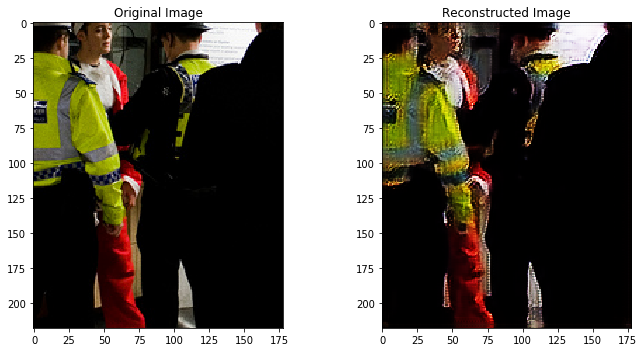

[5/9][50/1272] Loss_D: 1.3752	Loss_G: 1.1333	Loss_E: 1.1304	D(x): 0.4790	D(G(z)): 0.4700/0.4623	Progress: 56.00%	Elapsed: 02:28:33	Remaining: 01:56:42
[5/9][100/1272] Loss_D: 1.3644	Loss_G: 1.1214	Loss_E: 1.1257	D(x): 0.5094	D(G(z)): 0.4953/0.4944	Progress: 56.44%	Elapsed: 02:29:40	Remaining: 01:55:31
[5/9][150/1272] Loss_D: 1.3703	Loss_G: 1.1327	Loss_E: 1.1328	D(x): 0.5967	D(G(z)): 0.5687/0.4721	Progress: 56.87%	Elapsed: 02:30:47	Remaining: 01:54:20
[5/9][200/1272] Loss_D: 1.3550	Loss_G: 1.0848	Loss_E: 1.0839	D(x): 0.5425	D(G(z)): 0.5211/0.4965	Progress: 57.31%	Elapsed: 02:31:54	Remaining: 01:53:09
[5/9][250/1272] Loss_D: 1.3847	Loss_G: 1.1403	Loss_E: 1.1404	D(x): 0.4849	D(G(z)): 0.4816/0.4939	Progress: 57.75%	Elapsed: 02:33:01	Remaining: 01:51:58
[5/9][300/1272] Loss_D: 1.3761	Loss_G: 1.0635	Loss_E: 1.0652	D(x): 0.5302	D(G(z)): 0.5191/0.5040	Progress: 58.18%	Elapsed: 02:34:09	Remaining: 01:50:46
[5/9][350/1272] Loss_D: 1.3587	Loss_G: 1.0571	Loss_E: 1.0615	D(x): 0.5350	D(G(z)): 0.5196

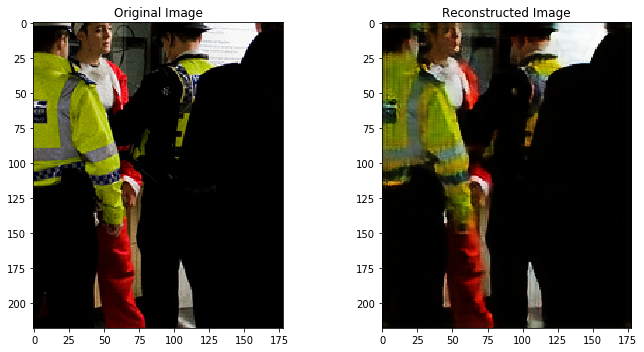

[5/9][550/1272] Loss_D: 1.3550	Loss_G: 1.0593	Loss_E: 1.0589	D(x): 0.5150	D(G(z)): 0.4961/0.4851	Progress: 60.37%	Elapsed: 02:39:45	Remaining: 01:44:52
[5/9][600/1272] Loss_D: 1.3910	Loss_G: 1.1630	Loss_E: 1.1656	D(x): 0.5796	D(G(z)): 0.5642/0.4853	Progress: 60.81%	Elapsed: 02:40:54	Remaining: 01:43:43
[5/9][650/1272] Loss_D: 1.3934	Loss_G: 1.2449	Loss_E: 1.2471	D(x): 0.5261	D(G(z)): 0.5257/0.4569	Progress: 61.24%	Elapsed: 02:42:01	Remaining: 01:42:32
[5/9][700/1272] Loss_D: 1.3986	Loss_G: 1.0358	Loss_E: 1.0368	D(x): 0.4935	D(G(z)): 0.4984/0.5271	Progress: 61.68%	Elapsed: 02:43:08	Remaining: 01:41:21
[5/9][750/1272] Loss_D: 1.3841	Loss_G: 1.0577	Loss_E: 1.0568	D(x): 0.5407	D(G(z)): 0.5344/0.5243	Progress: 62.12%	Elapsed: 02:44:15	Remaining: 01:40:11
[5/9][800/1272] Loss_D: 1.3628	Loss_G: 1.0285	Loss_E: 1.0293	D(x): 0.5237	D(G(z)): 0.5081/0.5143	Progress: 62.55%	Elapsed: 02:45:23	Remaining: 01:39:00
[5/9][850/1272] Loss_D: 1.3894	Loss_G: 1.0790	Loss_E: 1.0817	D(x): 0.5136	D(G(z)): 0.513

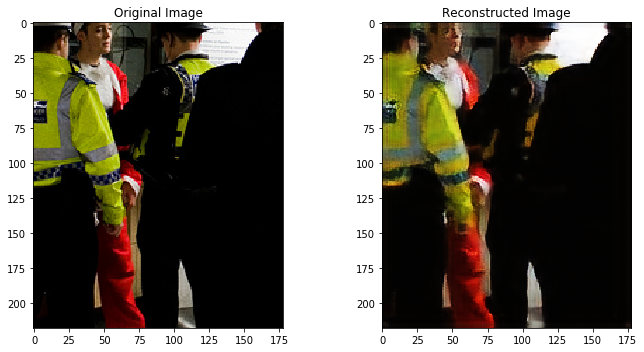

[5/9][1050/1272] Loss_D: 1.3959	Loss_G: 1.1043	Loss_E: 1.1036	D(x): 0.5335	D(G(z)): 0.5364/0.5130	Progress: 64.74%	Elapsed: 02:51:02	Remaining: 01:33:10
[5/9][1100/1272] Loss_D: 1.3708	Loss_G: 1.1156	Loss_E: 1.1151	D(x): 0.5122	D(G(z)): 0.5027/0.4851	Progress: 65.17%	Elapsed: 02:52:09	Remaining: 01:32:00
[5/9][1150/1272] Loss_D: 1.3902	Loss_G: 1.0715	Loss_E: 1.0694	D(x): 0.4994	D(G(z)): 0.4979/0.4887	Progress: 65.61%	Elapsed: 02:53:17	Remaining: 01:30:50
[5/9][1200/1272] Loss_D: 1.3643	Loss_G: 1.0374	Loss_E: 1.0386	D(x): 0.5207	D(G(z)): 0.5057/0.4938	Progress: 66.05%	Elapsed: 02:54:27	Remaining: 01:29:41
[5/9][1250/1272] Loss_D: 1.3723	Loss_G: 1.1741	Loss_E: 1.1714	D(x): 0.4990	D(G(z)): 0.4840/0.4544	Progress: 66.48%	Elapsed: 02:55:39	Remaining: 01:28:33
[6/9][0/1272] Loss_D: 1.3724	Loss_G: 1.0416	Loss_E: 1.0417	D(x): 0.5304	D(G(z)): 0.5217/0.5103	Progress: 66.68%	Elapsed: 02:56:10	Remaining: 01:28:02


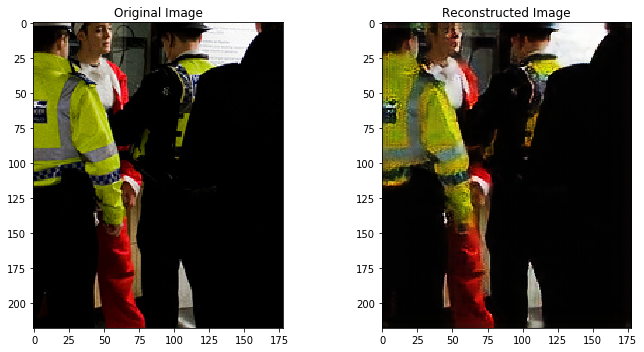

[6/9][50/1272] Loss_D: 1.3697	Loss_G: 1.0691	Loss_E: 1.0711	D(x): 0.5026	D(G(z)): 0.4917/0.5019	Progress: 67.11%	Elapsed: 02:57:18	Remaining: 01:26:53
[6/9][100/1272] Loss_D: 1.4104	Loss_G: 1.1565	Loss_E: 1.1575	D(x): 0.4663	D(G(z)): 0.4768/0.5111	Progress: 67.55%	Elapsed: 02:58:25	Remaining: 01:25:43
[6/9][150/1272] Loss_D: 1.3635	Loss_G: 1.0420	Loss_E: 1.0448	D(x): 0.5196	D(G(z)): 0.5046/0.4902	Progress: 67.99%	Elapsed: 02:59:33	Remaining: 01:24:33
[6/9][200/1272] Loss_D: 1.3801	Loss_G: 1.0366	Loss_E: 1.0384	D(x): 0.4784	D(G(z)): 0.4721/0.4923	Progress: 68.42%	Elapsed: 03:00:42	Remaining: 01:23:23
[6/9][250/1272] Loss_D: 1.4008	Loss_G: 1.0413	Loss_E: 1.0414	D(x): 0.5382	D(G(z)): 0.5407/0.5253	Progress: 68.86%	Elapsed: 03:01:49	Remaining: 01:22:13


In [ ]:
import time
import csv

# Initialize time tracking
start_time = time.time()

# Lists to keep track of progress
G_losses = []
D_losses = []
E_losses = []
iters = 0
num_epochs = 9

# Save losses to CSV
loss_file = "losses.csv"
with open(loss_file, mode="w") as f:
    writer = csv.writer(f)
    writer.writerow(["Epoch", "Batch", "G_loss", "D_loss", "E_loss"])

print("Starting Training Loop...")

# Training Loop
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    
    # For each batch in the dataloader
    for i, (images) in enumerate(dataloader, 0):
        netG.train()
        netD.train()
        netE.train()
        
        netD.zero_grad()
        
        images = images.to(device)
        fake_images = netG(netE(images))
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        inp_x = {'img': images, 'encoded': netE(images)}
        label = torch.FloatTensor(np.random.uniform(low=0.855, high=0.999, size=(images.size(0)))).to(device)
        output = netD(inp_x).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward(retain_graph=True)
        D_x = output.mean().item()
        
        inp_x_fake = {'img': fake_images, 'encoded': netE(images)}
        label = torch.FloatTensor(np.random.uniform(low=0.005, high=0.155, size=(images.size(0)))).to(device)
        output = netD(inp_x_fake).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward(retain_graph=True)
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        inp_x_fake = {'img': fake_images, 'encoded': netE(images)}
        label = torch.FloatTensor(np.random.uniform(low=0.895, high=0.999, size=(images.size(0)))).to(device)
        output = netD(inp_x_fake).view(-1)
        
        errG = criterion(output, label) + 4 * l1criterion(images, fake_images)
        errG.backward(retain_graph=True)
        D_G_z2 = output.mean().item()
        optimizerG.step()

        ############################
        # (3) Update E network: minimize reconstruction loss
        ###########################
        netE.zero_grad()
        inp_x_fake = {'img': fake_images, 'encoded': netE(images)}
        label = torch.FloatTensor(np.random.uniform(low=0.895, high=0.999, size=(images.size(0)))).to(device)
        output = netD(inp_x_fake).view(-1)
        
        errE = criterion(output, label) + 4 * l1criterion(images, fake_images)
        errE.backward(retain_graph=True)
        E_G_z2 = output.mean().item()
        optimizerE.step()
        
        #################################_______STATS________###########################################
        # Output training stats
        if i % 50 == 0:
            elapsed_time = time.time() - start_time
            progress = ((epoch * len(dataloader) + i + 1) / (num_epochs * len(dataloader))) * 100
            remaining_time = (elapsed_time / progress) * (100 - progress)
            
            print(
                f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}] "
                f"Loss_D: {errD:.4f}\tLoss_G: {errG:.4f}\tLoss_E: {errE:.4f}\t"
                f"D(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}\t"
                f"Progress: {progress:.2f}%\tElapsed: {time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}\t"
                f"Remaining: {time.strftime('%H:%M:%S', time.gmtime(remaining_time))}"
            )

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        E_losses.append(errE.item())
        with open(loss_file, mode="a") as f:
            writer = csv.writer(f)
            writer.writerow([epoch, i, errG.item(), errD.item(), errE.item()])
        
        # Periodic Image Reconstruction and Visualization
        if i % 500 == 0:
            netE.eval()
            netG.eval()
            encoded_img = netE(valid_batch)
            reconstructed_img = netG(encoded_img)
            
            # Adjust subplot dimensions for single or multiple images
            if num_images_to_show == 1:
                f, axarr = plt.subplots(1, 2, figsize=(10, 5))
                validimg = (valid_batch[0].cpu().detach().permute(1, 2, 0) * 0.5) + 0.5
                rec_img = (reconstructed_img[0].cpu().detach().permute(1, 2, 0) * 0.5) + 0.5
                axarr[0].imshow(validimg)
                axarr[0].set_title("Original Image")
                axarr[1].imshow(rec_img)
                axarr[1].set_title("Reconstructed Image")
            else:
                f, axarr = plt.subplots(num_images_to_show, 2, figsize=(10, 5 * num_images_to_show))
                for j in range(num_images_to_show):
                    validimg = (valid_batch[j].cpu().detach().permute(1, 2, 0) * 0.5) + 0.5
                    rec_img = (reconstructed_img[j].cpu().detach().permute(1, 2, 0) * 0.5) + 0.5
                    axarr[j, 0].imshow(validimg)
                    axarr[j, 0].set_title(f"Original Image {j+1}")
                    axarr[j, 1].imshow(rec_img)
                    axarr[j, 1].set_title(f"Reconstructed Image {j+1}")
            
            plt.tight_layout()
            plt.show()


        del images, inp_x_fake, inp_x, label, output
        torch.cuda.empty_cache()
        iters += 1


In [ ]:
valid_dataset = ImageData(is_train=False)
batch_size=20
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
valid_batch = next(iter(valid_dataloader)).to(device)

In [ ]:
print(valid_batch.shape)
encoded_img = netE(valid_batch)
print(encoded_img.shape)
reconstructed_img = netG(encoded_img)
print(reconstructed_img.shape)

In [ ]:
num_images_to_show = 5
f, axarr = plt.subplots(num_images_to_show,2)
for i in range(num_images_to_show):
    validimg = (valid_batch[i].cpu().detach().permute(1, 2, 0) * 0.5) + 0.5
    rec_img = (reconstructed_img[i].cpu().detach().permute(1, 2, 0) *0.5) + 0.5
    axarr[i,0].imshow(validimg)
    axarr[i,1].imshow(rec_img)
    f.set_figheight(20)
    f.set_figwidth(20)
plt.show()

In [ ]:
torch.save(netE.state_dict(), "netE"+str(num_channels_in_encoder)+".model")
torch.save(netG.state_dict(), "netG"+str(num_channels_in_encoder)+".model")

In [1]:
df = pd.read_csv("losses.csv")
df.head()

,Epoch,Batch,G_loss,D_loss,E_loss
0,0,0,2.986004,1.386725,2.986892
1,0,1,2.891272,1.391100,2.891017
2,0,2,2.549356,1.386570,2.552811
3,0,3,2.885237,1.387105,2.885581
4,0,4,2.706389,1.385514,2.706756


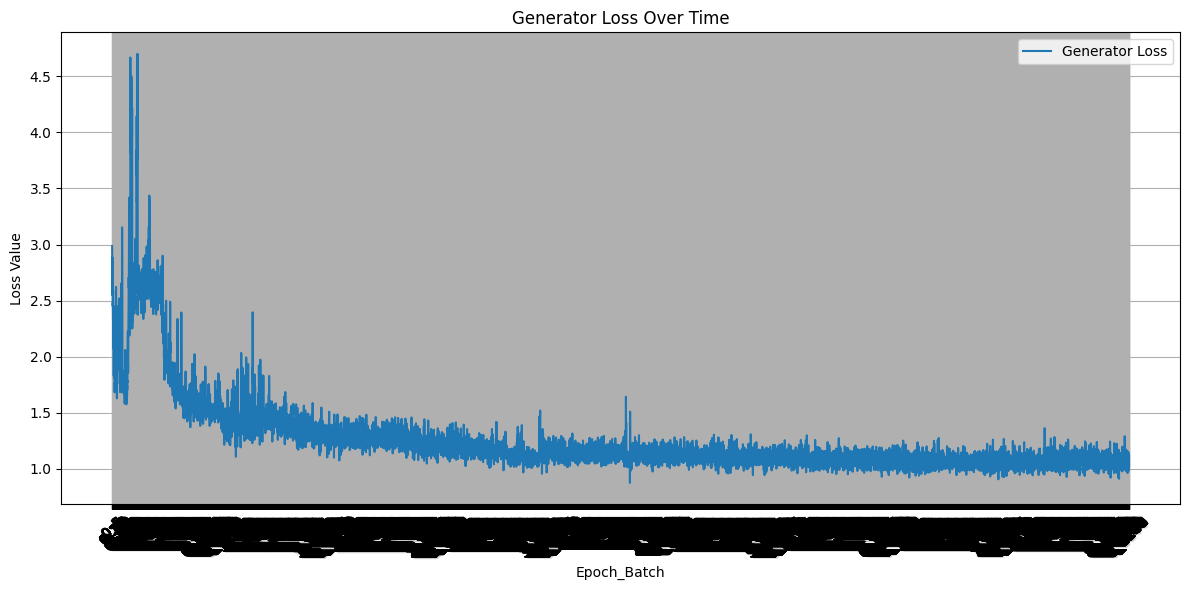

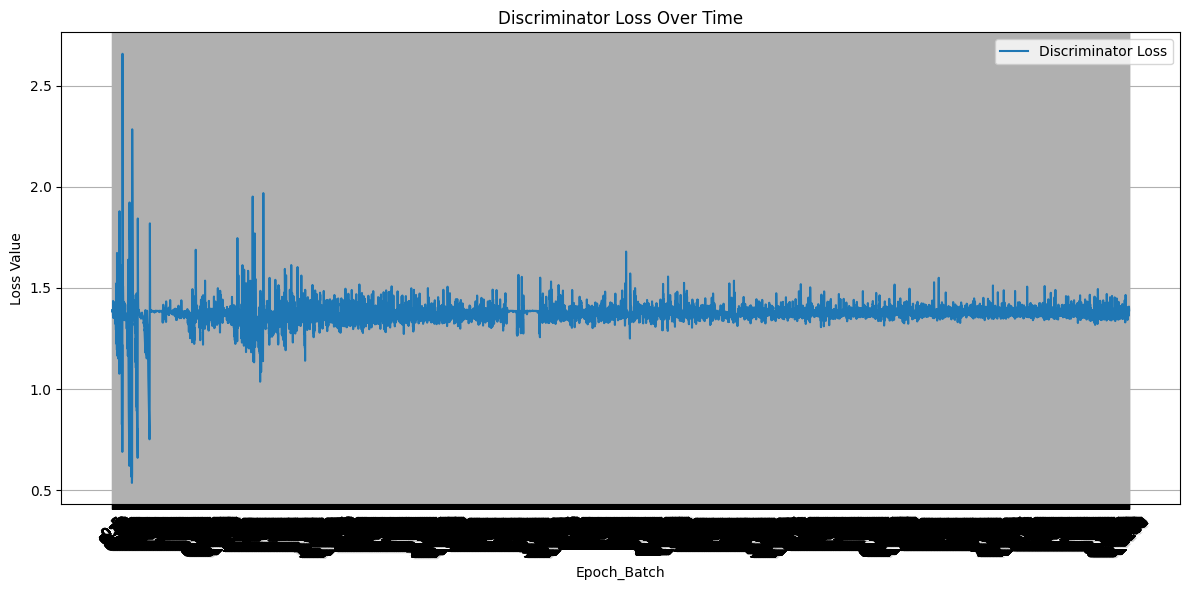

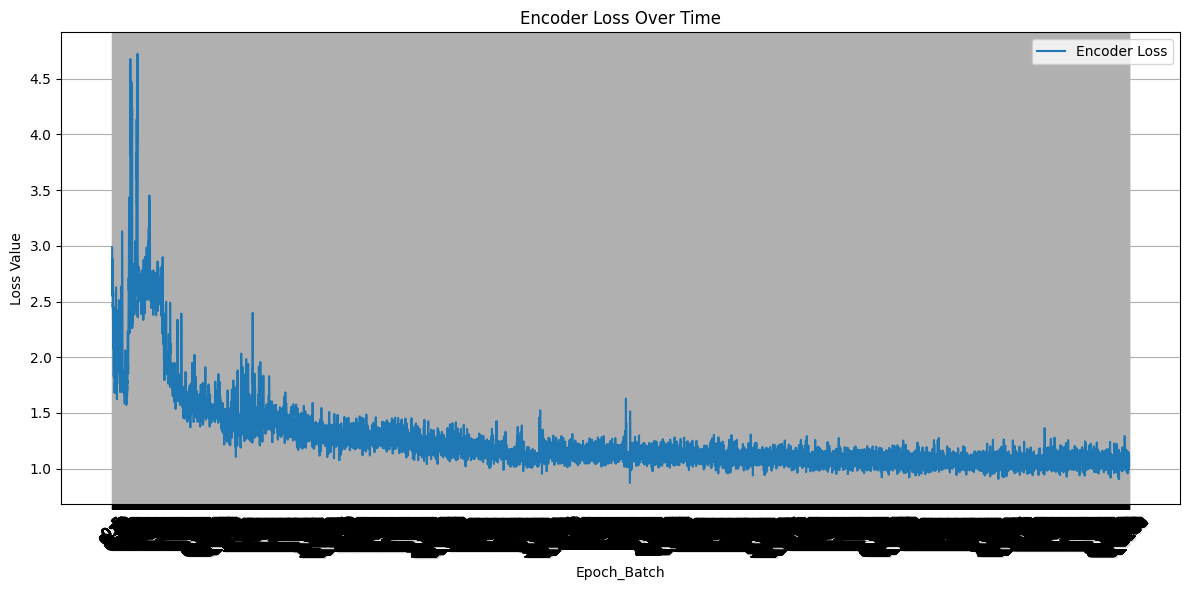

In [2]:
# Plotting Generator Loss
plt.figure(figsize=(12, 6))
plt.plot(df['Epoch'].astype(str) + '_' + df['Batch'].astype(str), df['G_loss'], label='Generator Loss')
plt.xlabel('Epoch_Batch')
plt.ylabel('Loss Value')
plt.title('Generator Loss Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting Discriminator Loss
plt.figure(figsize=(12, 6))
plt.plot(df['Epoch'].astype(str) + '_' + df['Batch'].astype(str), df['D_loss'], label='Discriminator Loss')
plt.xlabel('Epoch_Batch')
plt.ylabel('Loss Value')
plt.title('Discriminator Loss Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting Encoder Loss
plt.figure(figsize=(12, 6))
plt.plot(df['Epoch'].astype(str) + '_' + df['Batch'].astype(str), df['E_loss'], label='Encoder Loss')
plt.xlabel('Epoch_Batch')
plt.ylabel('Loss Value')
plt.title('Encoder Loss Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
